<a href="https://colab.research.google.com/github/amasoudi1/CT_PML/blob/master/UNET_Fixed_Gantry3_MUX5_4000_1e9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Making Google Drive Ready

In [0]:
!pip install -q pyyaml  # pyyaml is an optional
!pip install -U -q PyDrive  # PyDrive you can upload/download read and write data
from google.colab import files
from IPython.display import Image

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
cd /content/gdrive/'My Drive'/'Colab Notebooks'/

/content/gdrive/My Drive/Colab Notebooks


In [4]:
ls

 bagdata/
 bags_conv_1.mat
 bags_conv_2.mat
 bags_conv_3.mat
 bags_conv_4.mat
 bags_conv_5.mat
 bags_conv_6.mat
 bags_conv_7.mat
 bags_conv_8.mat
 bags_conv_9.mat
 bags_nt_conv_1.mat
 bags_nt_conv_2.mat
'Copy of UNET_Fixed_Gantry3 (1).ipynb'
'Copy of UNET_Fixed_Gantry3_4000.ipynb'
'Copy of UNET_Fixed_Gantry3.ipynb'
'Copy of UNET_Fixed_Gantry3_MUX5_4000.ipynb'
 data_label/
 data_label_noisy/
 data_label_noisy_4000/
 data_noisy/
 data_reconstruction/
 data_reconstruction_noisy/
 data_recosntruction_noisy_4000/
 derenzo_conv_r.mat
 derenzo_mux5_r.mat
 derenzo_r.mat
 derenzo_t.mat
 FbpConvNet.ipynb
 label.mat
 model100.h5
 model100v2.h5
 model100v3.h5
 model100v4.h5
 model100v5.h5
 model1.h5
 model.h5
 recon.mat
 recon_mux5_1e9.mat
 recon_mux5.mat
 rfg.h5
 rfg_noisy_4000.h5
 rfg_noisy_4000_v2.h5
 rfg_noisy_4000_v3.h5
 rfg_noisy_4000_v4.h5
 rfg_noisy_mux5_4000_1e9_v1.h5
 rfg_noisy_mux5_4000.h5
 rfg_noisy_mux5_4000_v2.h5
 rfg_noisy_mux5_4000_v3.h5
 rfg_v1_noisy.h5
 rfg_v2.h5
 rfg_v3.h5
 rfg_

# 1. Introduction  : 

The X-Ray Computed Tomography (CT) has been widely used for bag screening purposes throughout the world. The X-ray CT machine goes through 4 steps before making the decision that the threat item is in the bag or not. As depicted in figure below  these steps are : 1- measurement aqusition (sinogram), 2- image reconstruction, 3- segmentation and 4- pattern recognition.



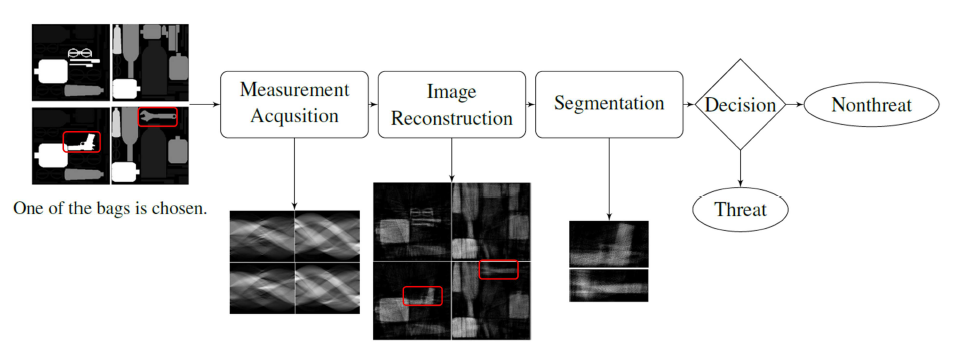

In [5]:
Image('steps.png', width = 700)

The measuerment process can be written as below mathematically

$$\bar{r} = J_0 \exp(-H\times f)$$

where $\bar{r}_{D\times 1}$ is the mean number of photons recieved by the detectors , $D$ is number of detectors, $f_{N^2\times 1}$ is the attenuation coefficients of a bag of size $N\times N$ pixels, which is flattened into 1-dimensional vector, and $H_{D\times N^2}$ is the system matrix where  $H_{i,j}$ is the intersection of ray that goes through pixel $j$ and recieved by the detector $i$. 

Because the measutement is dominated by shot-noise, we model the measurement $r$ by Poisson Process:

$$r = \text{Poiss}(\bar{r})$$

The goal of this project is to recover the bag $f$ attenuation coefficent from measurent vecor $r$ using **Convolutional Neural Network (CNN)**. So the goal is to solve an **inverse problem** using CNN. 

It is important to note that we do not feed the CNN the raw measurement $r$ and instead we feed the CNN an rough estimated of $f$. This is becuase to solve the inverse problem directly the CNN needs to learn the inverse of $H$ which is computationally expensive  which increases the number of layres in CNN severly. For more information on this check '*Convolutional neural networks for inverse problems in imaging: A review*' by McCann *et al.*

We use early-terminated maximum likelihood  estimation  to produce noisy estimated of $f$ very fast and call them $\hat{f}$. We use this noisy estimate $\hat{f}$ and the ground truth $f$ to train the CNN.  Clearly at this stage, we convert the problem from inverse problem  into **image denoising** problem. 

The network used here is based on U-NET which is used widely for image segmentation (*'U-net: Convolutional networks for biomedical image segmentation'*, by O. Ronneberger *et al.*). 

We add a residual to the U-Net network as it is described in *'Deep Convolutional Neural Network for
Inverse Problems in Imaging'* by K. H. Jin *et al.* and *'Framing U-Net via Deep Convolutional
Framelets: Application to Sparse-View CT'* by Y. Han *et al.*

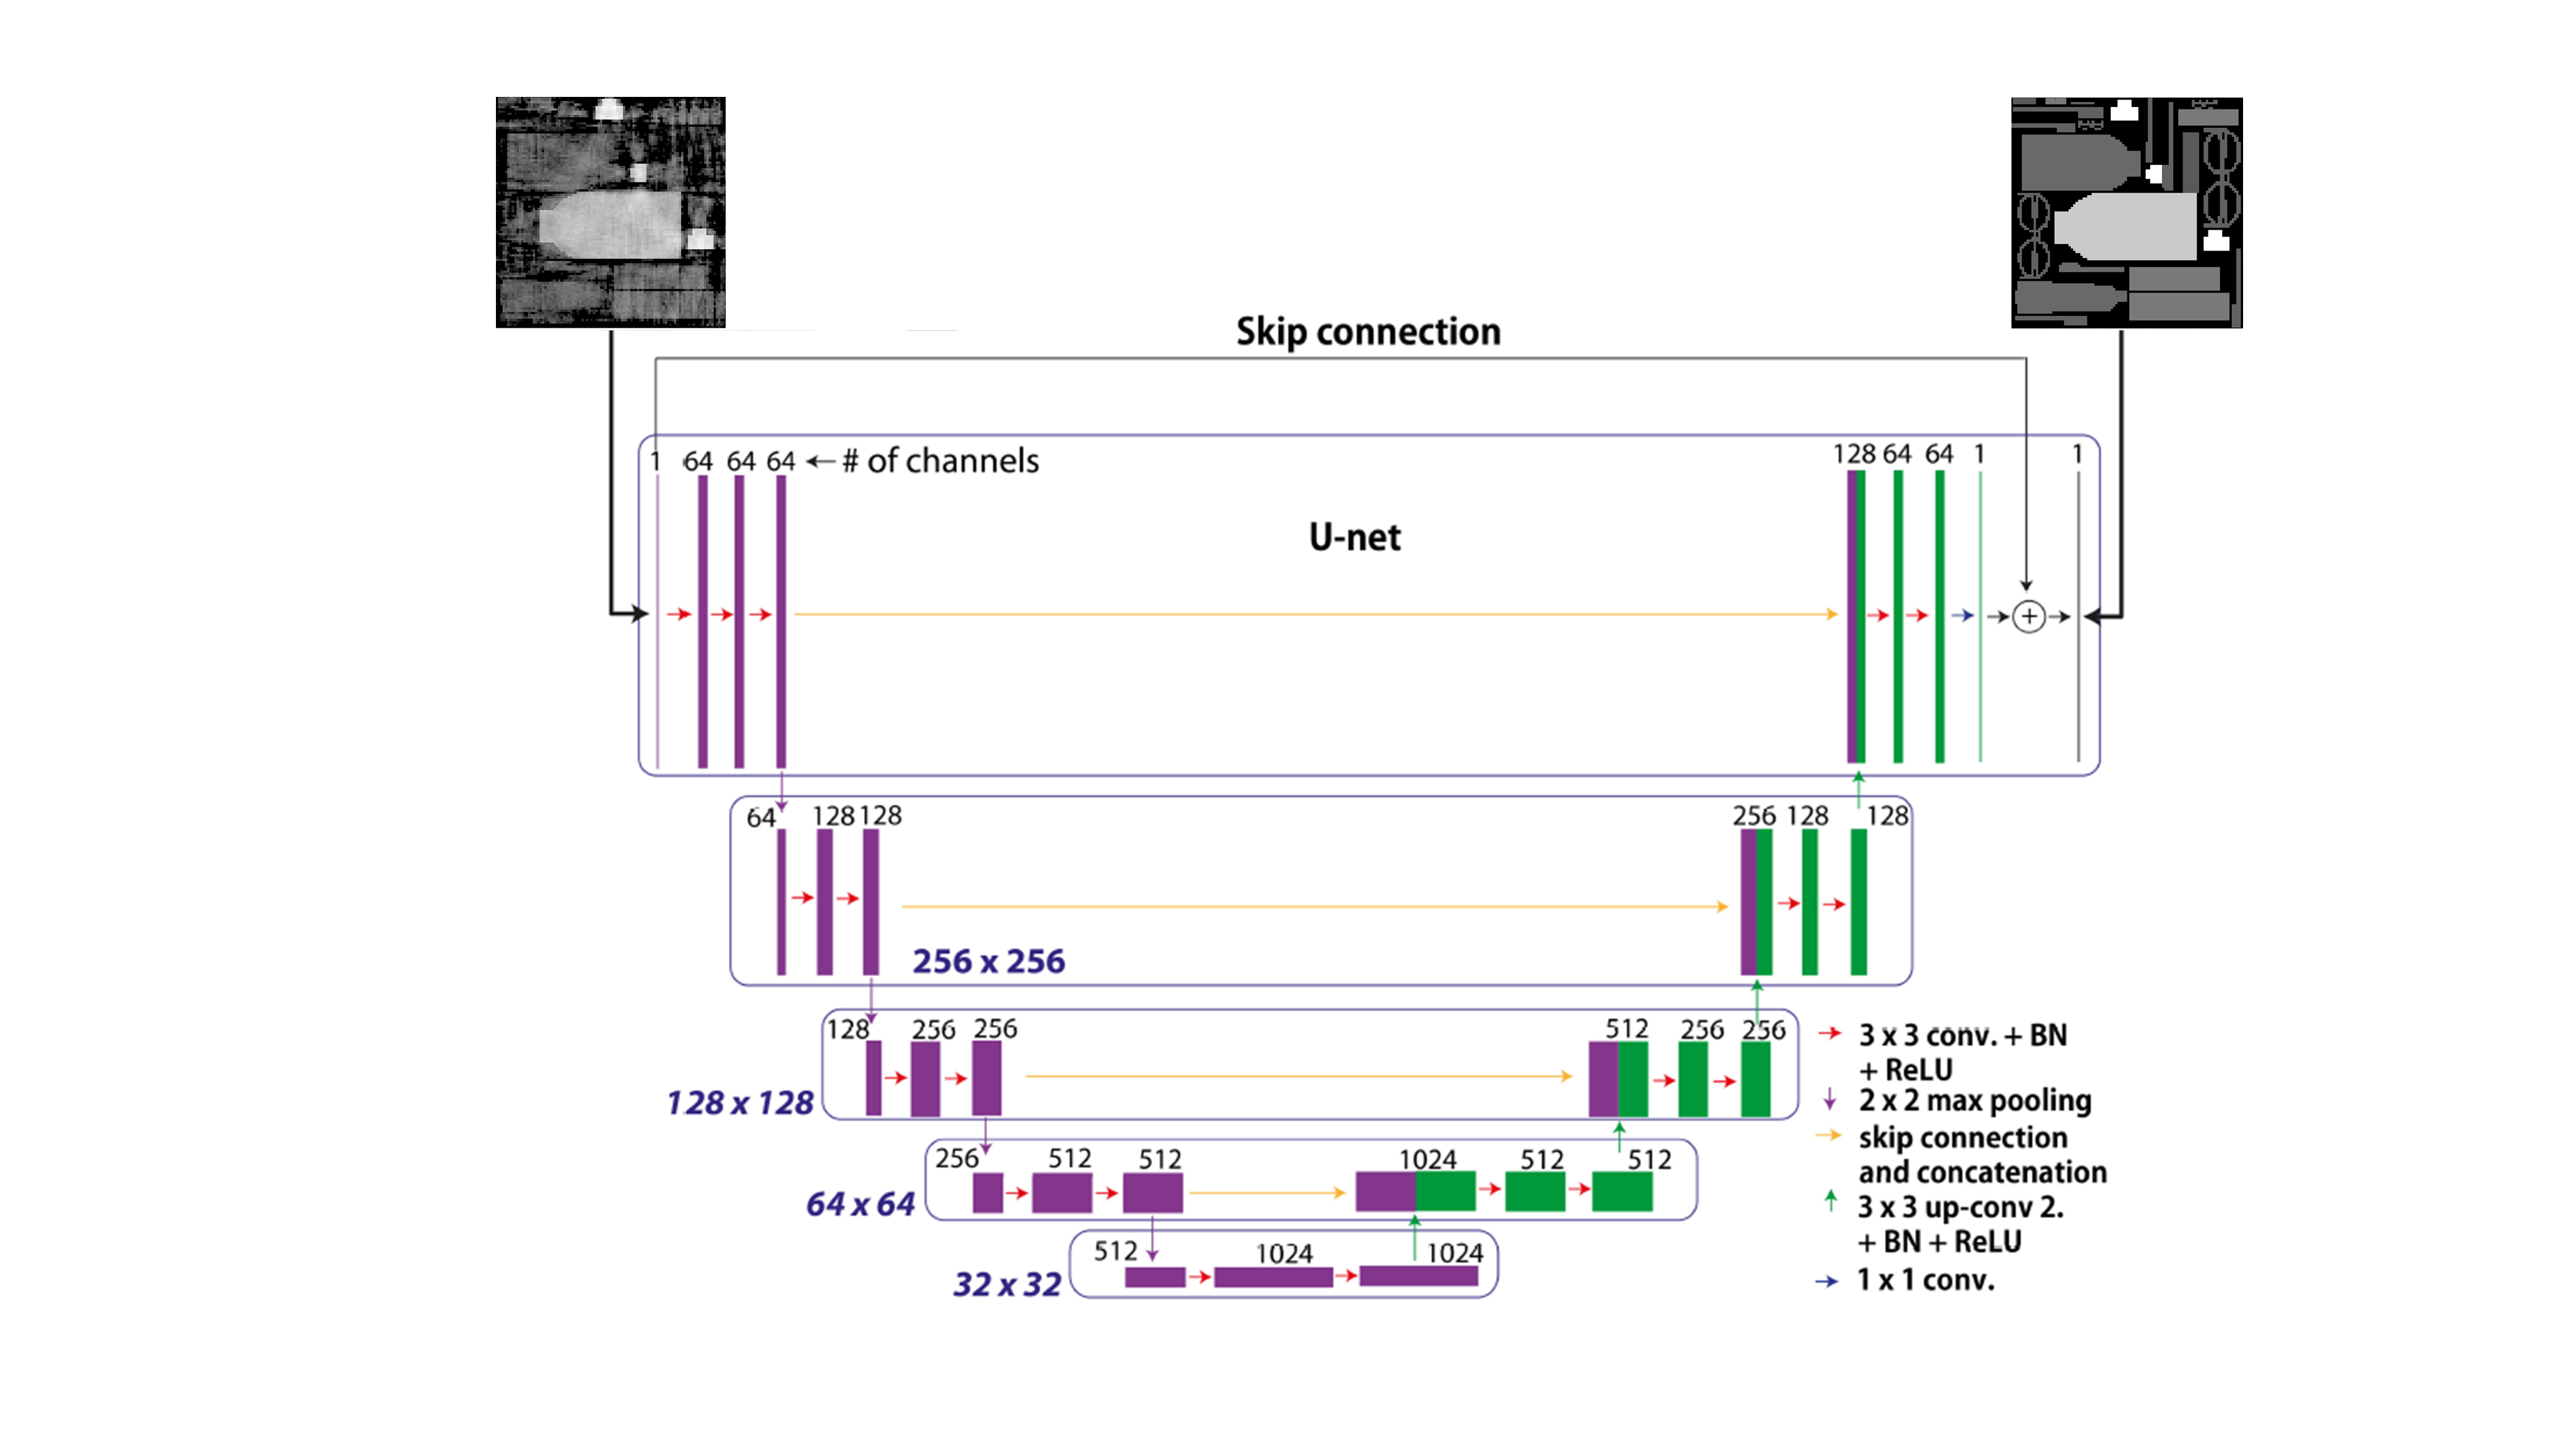

In [6]:
Image('u-net.png', width = 700)

In [7]:
#from tensorflow.keras.models import *
#from tensorflow.keras.layers import *
#from tensorflow.keras.optimizers import *
#from tensorflow.keras.initializers import *
#from tf.keras.callbacks import ModelCheckpoint, LearningRateScheduler
#from tf.keras import backend as keras
import os
import sys

from keras.models import Model
from keras.layers import *
from keras.optimizers import *
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
import keras.backend as K
from keras.callbacks import LearningRateScheduler, ModelCheckpoint ,Callback
from keras.initializers import *

import cv2
import numpy as np
import scipy.io as sc
import os
import sys
from sklearn.utils import shuffle
#from scipy.ndimage import imread
from imageio import imread
#from scipy.misc import imresize
import matplotlib.pyplot as plt

#np.random.seed(0)
#tf.set_random_seed(0)
#print(tf.VERSION)
#print(tf.keras.__version__)

################################################################# Reading Data

train_images = np.zeros(shape=(7927,100,100,1))
train_labels = np.zeros(shape=(7927,100,100,1))

val_images = np.zeros(shape=(1500,100,100,1))
val_labels = np.zeros(shape=(1500,100,100,1))

test_images = np.zeros(shape=(1500,100,100,1))
test_labels = np.zeros(shape=(1500,100,100,1))

np.random.seed(seed=42)
indx = np.arange(10927)
np.random.shuffle(indx)
print(indx[0:10])

image_temp = sc.loadmat("recon_mux5_1e9.mat")
label_temp = sc.loadmat("label.mat")

images = np.expand_dims(np.array(image_temp['recon']),axis = 3)
labels = np.expand_dims(np.array(label_temp['label']),axis = 3)


train_images = images[indx[1:8927],:,:]
train_labels = labels[indx[1:8927],:,:]

val_images = images[indx[8927:9927],:,:]
val_labels = labels[indx[8927:9927],:,:]

test_images = images[indx[9927:10927],:,:]
test_labels = labels[indx[9927:10927],:,:]

images.shape
labels.shape

print(indx[8927:8927+10])
print(indx[9927:9927+10])
#print(indx[1],indx[4],indx[8])
#print(indx[8927+0],indx[8927+4],indx[8927+8])
#print(indx[9927+0],indx[9927+4],indx[9927+8])

#################################################### --- get training data ---
#images_location = "./data_recosntruction_noisy_4000/"
#labels_location = "./data_label_noisy_4000/"

#for i in range(7927): 
#     if i % 500== 0:
#       print(i)      
#     image_temp = sc.loadmat(images_location + str(indx[i]+1) + ".mat")    
#     train_images[i,:,:]   = np.expand_dims(np.array(image_temp['r']),axis=2)
    
#     label_temp = sc.loadmat(labels_location + str(indx[i]+1) + ".mat")    
#     train_labels[i,:,:]   = np.expand_dims(np.array(label_temp['t']),axis=2)
    
                
#################################################### --- get test data ---
      
# counter = 0  
# for i in range(7927,9427):          
#     if i % 500== 0:
#       print(i) 
#     image_temp = sc.loadmat(images_location + str(indx[i]+1) + ".mat")    
#     val_images[counter,:,:]   = np.expand_dims(np.array(image_temp['r']),axis=2)
    
#     label_temp = sc.loadmat(labels_location + str(indx[i]+1) + ".mat")    
#     val_labels[counter,:,:]   = np.expand_dims(np.array(label_temp['t']),axis=2)
#     counter += 1
    
# counter = 0  
# for i in range(9427,10927):      
#     if i % 500== 0:
#       print(i)   
#     image_temp = sc.loadmat(images_location + str(indx[i]+1) + ".mat")    
#     test_images[counter,:,:]   = np.expand_dims(np.array(image_temp['r']),axis=2)
    
#     label_temp = sc.loadmat(labels_location + str(indx[i]+1) + ".mat")    
#     test_labels[counter,:,:]   = np.expand_dims(np.array(label_temp['t']),axis=2)
#     counter += 1    
      
#train_images = 1*(train_images - train_images.min()) / (train_images.max() - train_images.min())
#train_labels = 1*(train_labels - train_labels.min()) / (train_labels.max() - train_labels.min())      
      

Using TensorFlow backend.


[ 2271  8698  3753  8665  4441  7868 10861   932  5279   304]
[ 1442  8453  4406 10424  1689 10782  9840  5962  2496  8972]
[2204  419  922 9446 8669 5408 5788 5742 7667 5567]


Done With Data


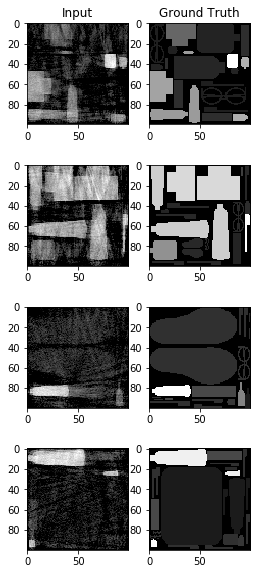

In [8]:
print("Done With Data")

########################################################### Adjusting Contrast
def adjust_gamma(image, gamma=1.0):
   image = 255*(image - image.min()) / (image.max() - image.min())
   invGamma = 1.0 / gamma
   table = np.array([
      ((i / 255.0) ** invGamma) * 255
      for i in np.arange(0, 256)])
   return cv2.LUT(image.astype(np.uint8), table.astype(np.uint8))


########################################################### sample training data  
fix, ax = plt.subplots(4,2, figsize=(4,10))
for i in range(4):
#      ax[i,0].imshow(train_images[i,:,:,0], cmap='gray')
#      ax[i,1].imshow(train_labels[i,:,:,0], cmap='gray')    
     ax[i,0].imshow(adjust_gamma((train_images[i,:,:]), 1.5), cmap='gray')    
     ax[i,1].imshow(adjust_gamma((train_labels[i,:,:]), 1.5), cmap='gray')    
    

ax[0,0].set_title('Input')
ax[0,1].set_title('Ground Truth')

plt.show()

################### Left Column : sample input, Right Column : sample label 

In [9]:
######################################################## Defining The U-Net
SEED = 42
#initializer = RandomNormal(mean=0.0, stddev=0.05, seed = SEED) 
initializer = glorot_normal(seed = SEED) 
inputs = Input(shape=(100,100,1))  # Returns a placeholder tensor

### Layers :
# LEVEL 1
L10 = Conv2D(1, (1, 1), activation='relu', padding='same',use_bias=True, kernel_initializer= initializer, bias_initializer='zeros')(inputs)
L11 = Conv2D(64, (1, 1), activation='relu', padding='same',use_bias=True, kernel_initializer= initializer, bias_initializer='zeros')(L10)
L11 = BatchNormalization()(L11)
L12 = Conv2D(64, (3, 3), activation='relu' , padding='same',use_bias=True, kernel_initializer= initializer, bias_initializer='zeros')(L11)
L12 = BatchNormalization()(L12)
L13 = Conv2D(64, (3, 3), activation='relu' , padding='same',use_bias=True, kernel_initializer= initializer, bias_initializer='zeros')(L12)
L13 = BatchNormalization()(L13)

# LEVEL 2
L20 = MaxPooling2D(pool_size=(2, 2), padding='valid')(L13)
L21 = Conv2D(128, (3, 3), activation='relu' , padding='same',use_bias=True, kernel_initializer= initializer, bias_initializer='zeros')(L20)
L21 = BatchNormalization()(L21)
L22 = Conv2D(128, (3, 3), activation='relu' , padding='same',use_bias=True, kernel_initializer= initializer, bias_initializer='zeros')(L21)
L22 = BatchNormalization()(L22)

# LEVEL 3
L30 = MaxPooling2D(pool_size=(2, 2), padding='valid')(L22)
L31 = Conv2D(256, (3, 3), activation='relu' , padding='same',use_bias=True, kernel_initializer= initializer, bias_initializer='zeros')(L30)
L31 = BatchNormalization()(L31)
L32 = Conv2D(256, (3, 3), activation='relu' , padding='same',use_bias=True, kernel_initializer= initializer, bias_initializer='zeros')(L31)
L32 = BatchNormalization()(L32)

# LEVEL 4
L40 = MaxPooling2D(pool_size=(2, 2), padding='valid')(L32)
L41 = Conv2D(512, (3, 3), activation='relu' , padding='same',use_bias=True, kernel_initializer= initializer, bias_initializer='zeros')(L40)
L41 = BatchNormalization()(L41)
L42 = Conv2D(512, (3, 3), activation='relu' , padding='same',use_bias=True, kernel_initializer= initializer, bias_initializer='zeros')(L41)
L42 = BatchNormalization()(L42)

# LEVEL 5
L50 = MaxPooling2D(pool_size=(2, 2), padding='valid')(L42)
L51 = Conv2D(1024, (3, 3), activation='relu' , padding='same',use_bias=True, kernel_initializer= initializer, bias_initializer='zeros')(L50)
L51 = BatchNormalization()(L51)
L52 = Conv2D(1024, (3, 3), activation='relu' ,padding='same',use_bias=True, kernel_initializer= initializer, bias_initializer='zeros')(L51)
L52 = BatchNormalization()(L52)

# LEVEL 4
L43_in = Conv2DTranspose(256, (3, 3), activation='relu' , strides=(2, 2) ,padding='same',use_bias=True, kernel_initializer= initializer, bias_initializer='zeros')(L52)
#L43_in = UpSampling2D(size=(2,2))(L52)
L43_in = BatchNormalization()(L43_in)
L43 = Conv2D(512, (3, 3), activation='relu' ,padding='same',use_bias=True, kernel_initializer= initializer, bias_initializer='zeros')(concatenate([L42,L43_in], axis = 3))
L43 = BatchNormalization()(L43)
L44 = Conv2D(512, (3, 3), activation='relu' ,padding='same',use_bias=True, kernel_initializer= initializer, bias_initializer='zeros')(L43)
L44 = BatchNormalization()(L44)

# LEVEL 3
L33_in = Conv2DTranspose(128, (3, 3), activation='relu', strides=(2, 2) ,padding='valid',use_bias=True, kernel_initializer= initializer, bias_initializer='zeros')(L44)
#L33_in = UpSampling2D(size=(2,2))(L44)
L33_in = BatchNormalization()(L33_in)
L33 = Conv2D(256, (3, 3), activation='relu' , padding='same',use_bias=True, kernel_initializer= initializer, bias_initializer='zeros')(concatenate([L32,L33_in], axis = 3))
L33 = BatchNormalization()(L33)
L34 = Conv2D(256, (3, 3), activation='relu' ,padding='same',use_bias=True, kernel_initializer= initializer, bias_initializer='zeros')(L33)
L34 = BatchNormalization()(L34)

# LEVEL 2
L23_in = Conv2DTranspose(64, (3, 3), activation='relu' , strides=(2, 2) ,padding='same',use_bias=True, kernel_initializer= initializer, bias_initializer='zeros')(L34)
#L23_in = UpSampling2D(size=(2,2))(L34)
L23_in = BatchNormalization()(L23_in)
L23 = Conv2D(128, (3, 3), activation='relu' ,padding='same',use_bias=True, kernel_initializer= initializer, bias_initializer='zeros')(concatenate([L22,L23_in], axis = 3))
L23 = BatchNormalization()(L23)
L24 = Conv2D(128, (3, 3), activation='relu' , padding='same',use_bias=True, kernel_initializer= initializer, bias_initializer='zeros')(L23)
L24 = BatchNormalization()(L24)

# LEVEL 1
L14_in = Conv2DTranspose(32, (3, 3), activation='relu' , strides=(2, 2) ,padding='same',use_bias=True, kernel_initializer= initializer, bias_initializer='zeros')(L24)
#L14_in = UpSampling2D(size=(2,2))(L24)
L14_in = BatchNormalization()(L14_in)
L14 = Conv2D(64, (3, 3), activation='relu' , padding='same',use_bias=True, kernel_initializer= initializer, bias_initializer='zeros')(concatenate([L13,L14_in], axis = 3))
L14 = BatchNormalization()(L14)
L15 = Conv2D(64, (3, 3), activation='relu' , padding='same',use_bias=True, kernel_initializer= initializer, bias_initializer='zeros')(L14)
L15 = BatchNormalization()(L15)
L16 = Conv2D(1, (1, 1), activation='relu' , padding='same',use_bias=True, kernel_initializer= initializer, bias_initializer='zeros')(L15)
feed_forward = Add()([L10,L16])
L17 = Conv2D(1, (1, 1), padding='same',use_bias=True, kernel_initializer= initializer, bias_initializer='zeros')(feed_forward)


model = Model(inputs=inputs, outputs=L17)
model.summary()




W0801 05:41:19.004739 139945390262144 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0801 05:41:19.022934 139945390262144 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0801 05:41:19.027439 139945390262144 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0801 05:41:19.080511 139945390262144 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0801 05:41:19.082031

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100, 100, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 100, 100, 1)  2           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 100, 100, 64) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 100, 100, 64) 256         conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

In [10]:
################################################# NRMSE : Normalized Mean Squared Error ###################################################
def NRMSE(image, label):
  image = image.flatten()
  label = label.flatten()
  image = (image - image.min())/(image.max() - image.min())
  label = (label - label.min())/(label.max() - label.min())
  
  return np.sqrt(np.mean((image - label)**2))*100

nrmse_test = NRMSE(train_images[3,:,:,0], train_labels[3,:,:,0])
print(nrmse_test)

8.357725753201926


In [0]:
################################################# Data Augmentation : Only Horizontal and Vertical Flip
def my_generator(x_train, y_train, batch_size):
    data_generator = ImageDataGenerator(horizontal_flip = True, vertical_flip = False).flow(x_train, x_train, batch_size, seed=SEED)
    mask_generator = ImageDataGenerator(horizontal_flip = True, vertical_flip = False).flow(y_train, y_train, batch_size, seed=SEED)
    while True:
        x_batch, _ = data_generator.next()
        y_batch, _ = mask_generator.next()
        yield x_batch, y_batch

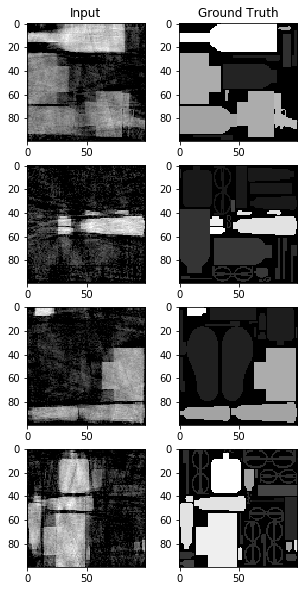

In [12]:
############################################## sample training data after augmentation
image_batch, mask_batch = next(my_generator(train_images, train_labels, 5))
fix, ax = plt.subplots(4,2, figsize=(5,10))
for i in range(4):
#     ax[i,0].imshow(image_batch[i,:,:,0], cmap='gray')
#     ax[i,1].imshow(mask_batch[i,:,:,0], cmap='gray')
    ax[i,0].imshow(adjust_gamma((image_batch[i,:,:,0]), 1.5), cmap='gray')    
    ax[i,1].imshow(adjust_gamma((mask_batch[i,:,:,0]), 1.5), cmap='gray')        
ax[0,0].set_title('Input')
ax[0,1].set_title('Ground Truth')    
plt.show()
################### Left Column : sample input, Right Column : sample label 

In [13]:
############################################### Training Using The optimizer

#sgd = SGD(lr=1e-4, momentum=0.99, nesterov = True, clipvalue=0.01)
#sgd = SGD(lr=1, momentum=0.99, clipvalue=0.01)
#sgd = tf.train.MomentumOptimizer(learning_rate = 0.01, momentum=0.99)

#class LossHistory(Callback):
#    def on_train_begin(self, logs={}):
#        self.losses = []
#
#    def on_batch_end(self, batch, logs={}):
#        self.losses.append(logs.get('loss'))


model.compile(Adam(lr = 2e-4), loss='mean_squared_error', metrics=['mean_absolute_error'])
#model.load_weights('rfg_noisy_mux5_4000_v3.h5')
#model.compile(sgd, loss='mean_squared_error', metrics=['mean_absolute_error'])

# weight_saver = ModelCheckpoint('./rfg_noisy_4000.h5', monitor='val_loss', 
#                                save_best_only=True, save_weights_only=True)

#annealer = LearningRateScheduler(lambda x: 0.99 ** x)

checkpoint = ModelCheckpoint('./rfg_noisy_mux5_4000_1e9_v1.h5', monitor='val_loss', 
                              save_best_only=True)

#callbacks_list = [checkpoint]

W0801 05:41:23.964536 139945390262144 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [0]:

#model.load_weights('rfg_v4.h5')
#model.compile(Adam(lr = 0.01), loss='mean_squared_error', metrics=['mean_absolute_error'])
#loss, acc = model.evaluate(train_images,train_labels)
#print((loss))
#print(acc/1000)

#history = LossHistory()
#hist = model.fit(train_images, train_labels, batch_size = 32, epochs = 2000, validation_data = (test_images,test_labels), 
#          shuffle = True ,verbose = 1, callbacks = [weight_saver,history])#, annealer])

# hist = model.fit_generator(my_generator(train_images, train_labels, 32), validation_data = (val_images,val_labels),
#                            epochs=2000, verbose=2, shuffle=True,
#                            steps_per_epoch = 200,
#                            callbacks = [weight_saver])#, annealer])

hist = model.fit_generator(my_generator(train_images, train_labels, 16), validation_data = (val_images,val_labels),
                           epochs=100, verbose=2, shuffle=True,
                           steps_per_epoch = 1674,
                           callbacks = [checkpoint])

Epoch 1/100
 - 750s - loss: 116957.9090 - mean_absolute_error: 321.7419 - val_loss: 70238.1882 - val_mean_absolute_error: 240.1544
Epoch 2/100


In [0]:
#import pickle
#file_pickle = open('trainHistoryDict_mux5', 'wb') 
#pickle.dump(hist, file_pickle)
#file_pickle.close()

#file_pickle = open('trainHistoryDictV3', 'rb')
#hist = pickle.load(file_pickle)


# print(hist.history.keys())

# index = 0
# fix, ax = plt.subplots(2,1, figsize=(20,8))
# #plt.yscale('log')
# loss_train = hist.history['loss']
# loss_val = hist.history['val_loss']
# ax[0].plot(loss_train[0:50])
# ax[0].set_title('Training Error : MSE')
# ax[0].set(xlabel = 'EPOCHS', ylabel = 'MSE')
# ax[1].plot(loss_val[0:50])
# ax[1].set_title('Validation Error : MSE')
# ax[1].set(xlabel = 'EPOCHS', ylabel = 'MSE')


loss, acc = model.evaluate(train_images,train_labels)
print(loss)
print(acc)

loss, acc = model.evaluate(val_images,val_labels)
print(loss)
print(acc)

loss, acc = model.evaluate(test_images,test_labels)
print(loss)
print(acc)

print('Training')

#image_batch, mask_batch = next(my_generator(train_images, train_labels, 5))
nrmse_train = np.zeros((3,2))
fix, ax = plt.subplots(3,3, figsize=(8,10))
for i in range(3):
    temp = model.predict( np.expand_dims( np.expand_dims(train_images[i*4,:,:,0], axis = 0), axis = 3 ))
#     ax[i,0].imshow(train_images[i,:,:,0], cmap='gray')
#     ax[i,1].imshow(train_labels[i,:,:,0], cmap='gray')    
#     ax[i,2].imshow(np.squeeze(temp), cmap='gray')
    ax[i,0].imshow(adjust_gamma(train_images[i*4,:,:,0],1.5), cmap='gray')
    ax[i,1].imshow(adjust_gamma(train_labels[i*4,:,:,0],1.5), cmap='gray')    
    ax[i,2].imshow(adjust_gamma(np.squeeze(temp),1.5), cmap='gray')    
    nrmse_train[i,0] = NRMSE(train_images[i*4,:,:],train_labels[i*4,:,:])
    nrmse_train[i,1] = NRMSE(temp,train_labels[i*4,:,:])    
ax[0,0].set_title('Input')
ax[0,1].set_title('Ground Truth')
ax[0,2].set_title('Output')
plt.show()
print(nrmse_train)

print('validation')

nrmse_val = np.zeros((3,2))
fix, ax = plt.subplots(3,3, figsize=(8,10))
for i in range(3):
    temp = model.predict( np.expand_dims( np.expand_dims(val_images[i*4,:,:,0], axis = 0), axis = 3 ))
    #ax[i,0].imshow(train_images[i,:,:,0], cmap='gray')
    #ax[i,1].imshow(train_labels[i,:,:,0], cmap='gray')    
    #ax[i,2].imshow(np.squeeze(temp), cmap='gray')
    ax[i,0].imshow(adjust_gamma(val_images[i*4,:,:,0],1.5), cmap='gray')
    ax[i,1].imshow(adjust_gamma(val_labels[i*4,:,:,0],1.5), cmap='gray')    
    ax[i,2].imshow(adjust_gamma(np.squeeze(temp),1.5), cmap='gray')    
    nrmse_val[i,0] = NRMSE(val_images[i*4,:,:],val_labels[i*4,:,:])
    nrmse_val[i,1] = NRMSE(temp,val_labels[i*4,:,:])    
ax[0,0].set_title('Input')
ax[0,1].set_title('Ground Truth')
ax[0,2].set_title('Output')
plt.show()
print(nrmse_val)

print('test')

nrmse_test = np.zeros((3,2))
fix, ax = plt.subplots(3,3, figsize=(8,10))
for i in range(3):
    temp = model.predict( np.expand_dims( np.expand_dims(test_images[i*4,:,:,0], axis = 0), axis = 3 ))
    #ax[i,0].imshow(train_images[i,:,:,0], cmap='gray')
    #ax[i,1].imshow(train_labels[i,:,:,0], cmap='gray')    
    #ax[i,2].imshow(np.squeeze(temp), cmap='gray')
    ax[i,0].imshow(adjust_gamma(test_images[i*4,:,:,0],1.5), cmap='gray')
    ax[i,1].imshow(adjust_gamma(test_labels[i*4,:,:,0],1.5), cmap='gray')    
    ax[i,2].imshow(adjust_gamma(np.squeeze(temp),1.5), cmap='gray')    
    nrmse_test[i,0] = NRMSE(test_images[i*4,:,:],test_labels[i*4,:,:])
    nrmse_test[i,1] = NRMSE(temp,test_labels[i*4,:,:])        
ax[0,0].set_title('Input')
ax[0,1].set_title('Ground Truth')
ax[0,2].set_title('Output')
plt.show()
print(nrmse_test)

# Test

In [0]:
#model.load_weights('rfg_v4.h5')
#model.compile(Adam(lr = 0.01), loss='mean_squared_error', metrics=['mean_absolute_error'])

loss, acc = model.evaluate(test_images,test_labels)
print(loss)
print(acc)
fix, ax = plt.subplots(3,3, figsize=(8,10))
for i in range(3):      
    temp = model.predict( np.expand_dims( np.expand_dims(test_images[i,:,:,0], axis = 0), axis = 3 ))
    #ax[i,0].imshow(test_images[i,:,:,0], cmap='gray')
    #ax[i,1].imshow(test_labels[i,:,:,0], cmap='gray')          
    #ax[i,2].imshow(np.squeeze(temp), cmap='gray')
    ax[i,0].imshow(adjust_gamma(test_images[i,:,:,0], 0.6) , cmap='gray')
    ax[i,1].imshow(adjust_gamma(test_labels[i,:,:,0], 1.5) , cmap='gray')          
    ax[i,2].imshow(adjust_gamma(np.squeeze(temp) , 1.5) , cmap='gray')    
ax[0,0].set_title('Input')
ax[0,1].set_title('Ground Truth')
ax[0,2].set_title('Output')

plt.show()